# 0~4.54h(N8)

N8
加工開始日：2022/05/30
加工終了日：2022/05/30
回転数：60000rpm
送り速度：1200mm/min
切り込み幅：0.1mm
切り込み深さ：0.1mm
加工時間：4.54h
加工のパターン：Li-Y-UD
コメント：no comment


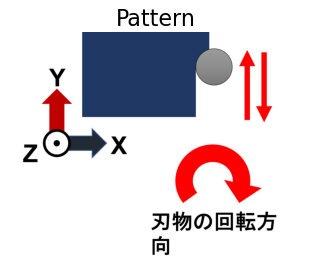

In [28]:
import py_module.negenovation as ngi
import numpy as np
import os
import matplotlib.pyplot as plt

par_dir = os.path.abspath(os.path.join( os.pardir ))
config = ngi.readyaml(par_dir)
ngi.show_pattern_img(config)
data_list = ngi.readNPY(par_dir)
_, length,_ = ngi.readtxt2(par_dir)

# 生データ

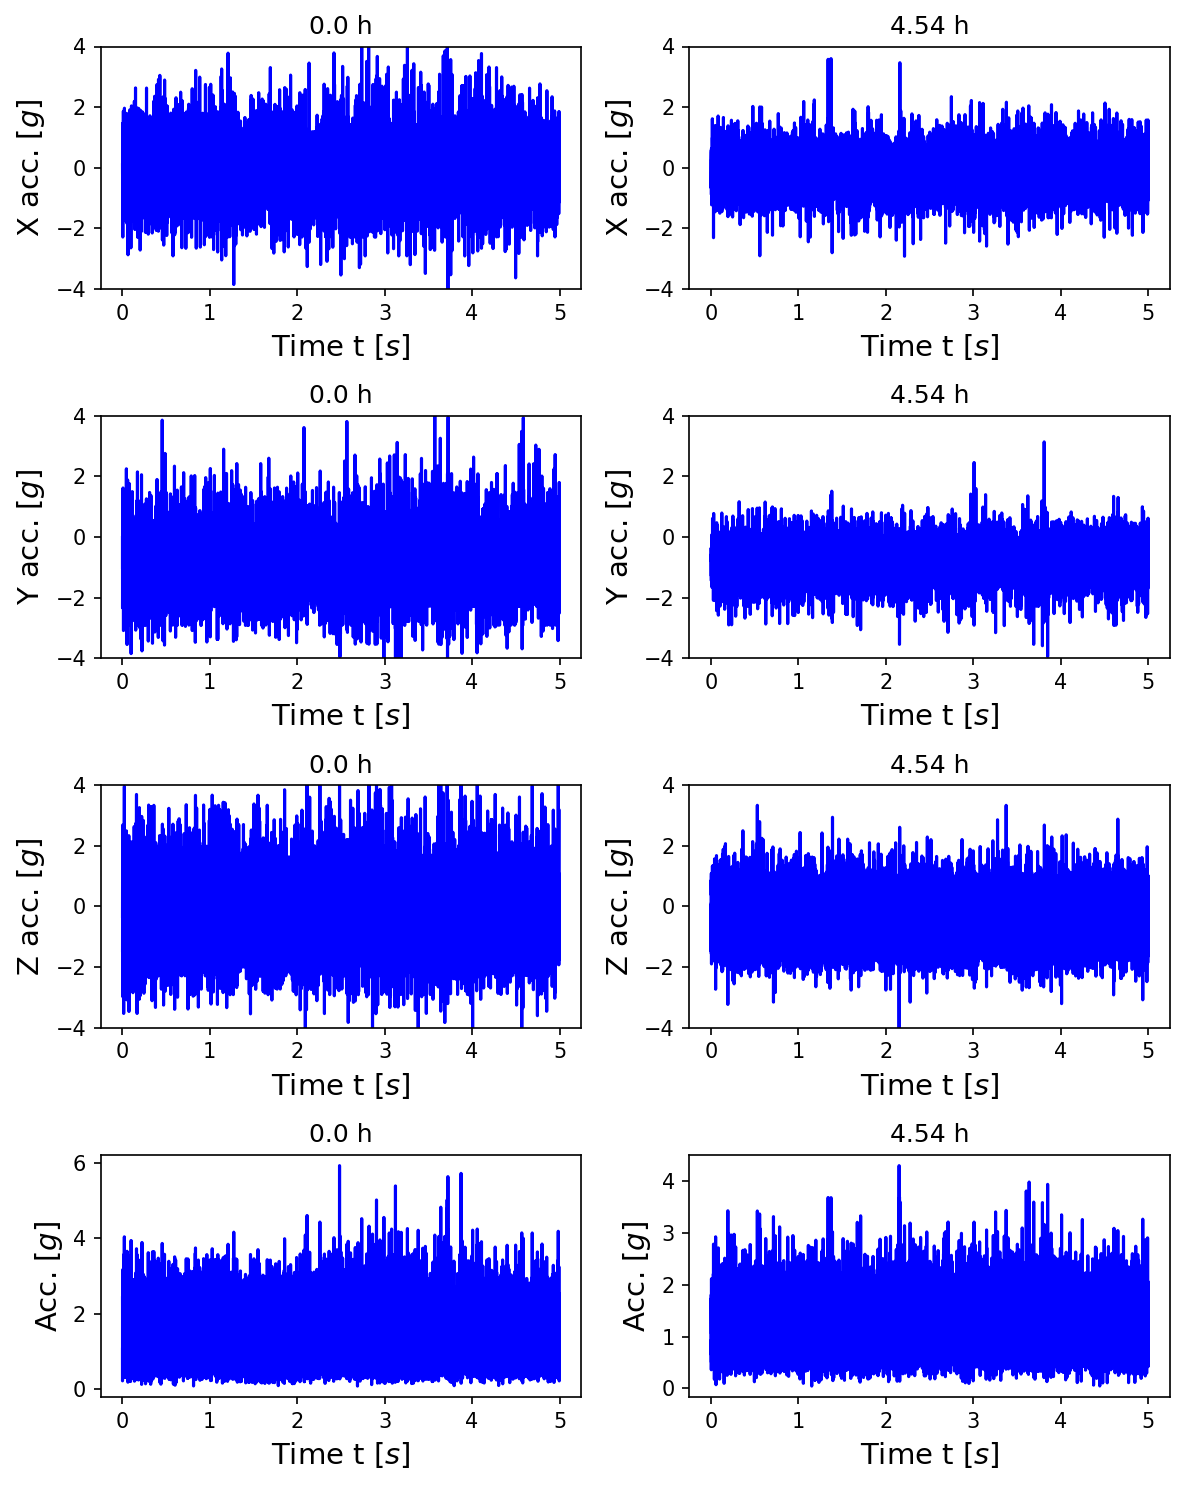

In [2]:
num_of_data = len(data_list)
s_rate = 80000#sampling frequency per sensor axis [Hz]

fig = plt.figure(0,dpi=150,figsize=(8,10))

counter = 0
labels = ["X","Y","Z"]

for i,data in enumerate(data_list):
    if (i==0) | (i==len(data_list)-1):
        #print(length[i,0])
        #3成分の合成
        acc_data = np.sqrt(data[200:-100,0]**2 + data[200:-100,1]**2 + data[200:-100,2]**2)

        data_size_row = data.shape[0]
        t_stamp = np.array(range(0, data_size_row-100))/s_rate
        
        
        for j,indx in enumerate([1,2,0]):
            ax = fig.add_subplot(4,2,(j*2)+1+counter)
            ax.plot(t_stamp[200:],data[200:-100,indx],color='b')
            ax.set_title(str(round(length[i,0],2))+" h")
            ax.set_xlabel("Time t [$s$]",fontsize=14)
            ax.set_ylabel(labels[j] + " acc. [$g$]",fontsize=14)
            ax.set_ylim(-4,4)
        #ax.set_xlim(0,0.005)
        ax = fig.add_subplot(4,2,7+counter)
        ax.plot(t_stamp[200:],acc_data,color='b')
        ax.set_title(str(round(length[i,0],2))+" h")
        ax.set_xlabel("Time t [$s$]",fontsize=14)
        ax.set_ylabel("Acc. [$g$]",fontsize=14)
        counter = counter + 1
    
    

fig.tight_layout()
plt.show()

# FFT解析結果

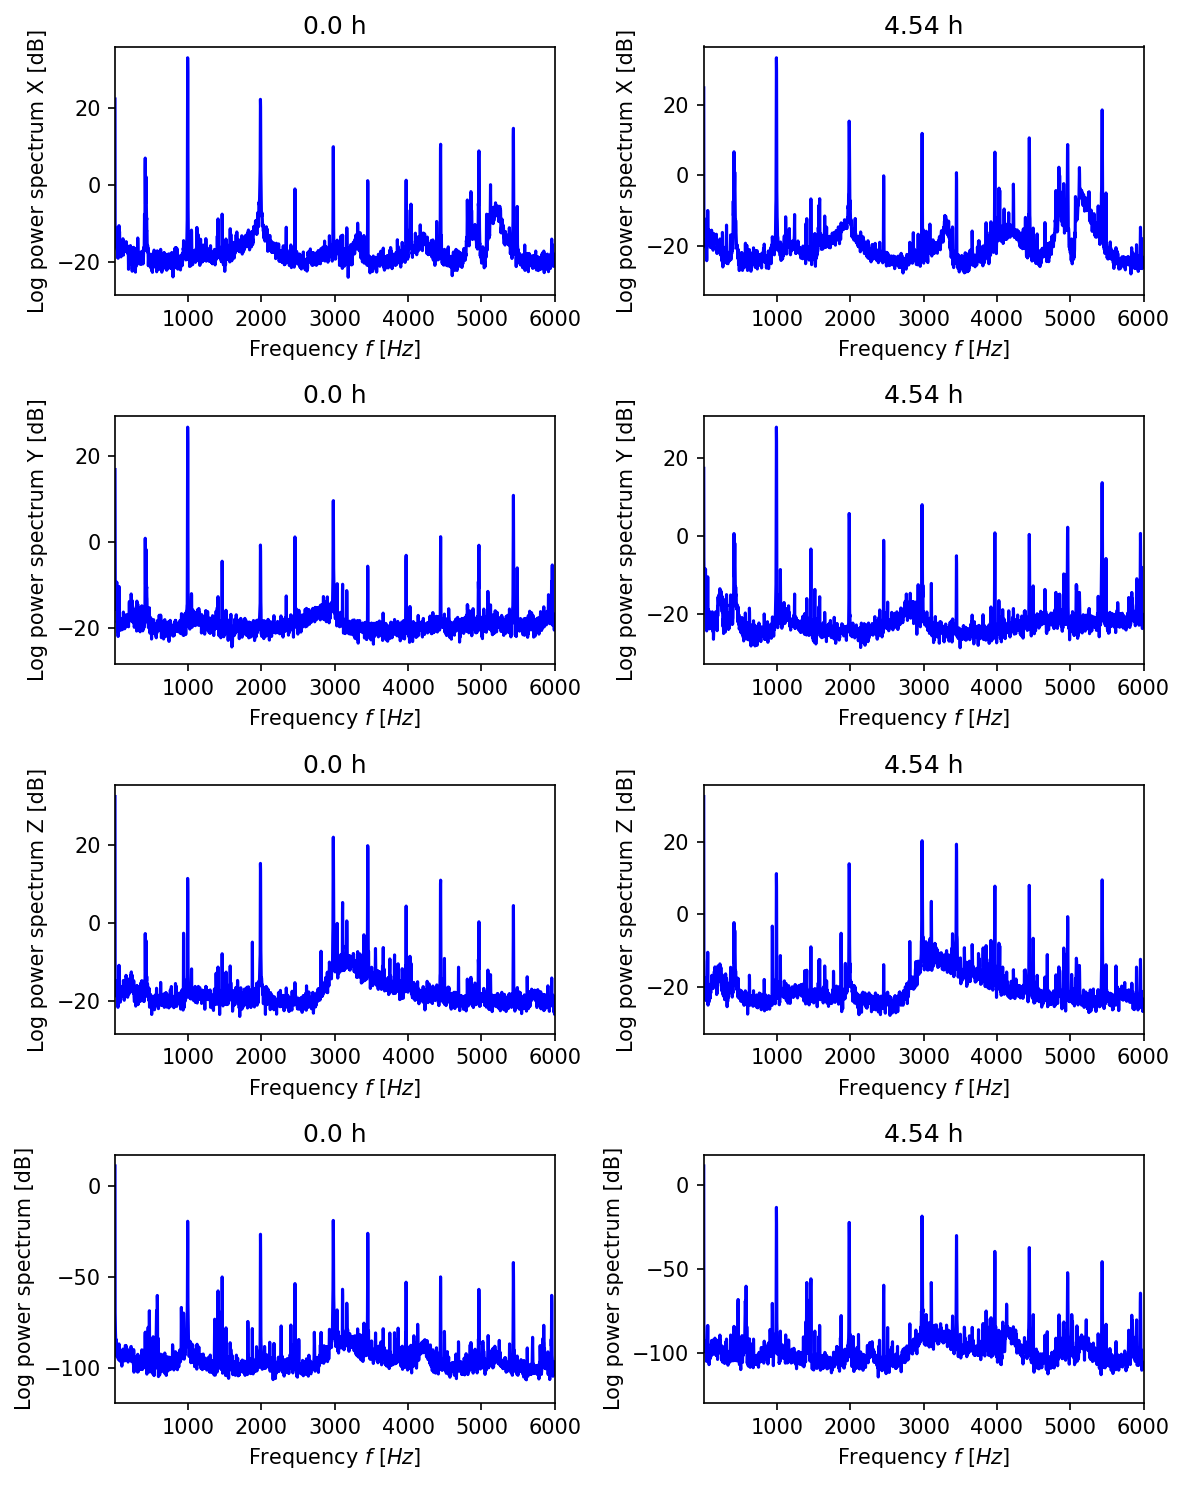

In [23]:
fig = plt.figure(2,dpi=150,figsize=(8,10))

counter = 0
labels = ["X","Y","Z"]

for i,data in enumerate(data_list):
    
    if (i==0) | (i==len(data_list)-1):
        
        #3成分の合成
        acc_data = np.sqrt(data[200:-100,0]**2 + data[200:-100,1]**2 + data[200:-100,2]**2)

        data_size_row = data.shape[0]
        t_stamp = np.array(range(0, data_size_row-100))/s_rate
        
        
        for j,indx in enumerate([0,1,2]):
            
            fft_result = ngi.myFFT(data[200:-100,indx],1/s_rate,0.1,0.4)
            
            ax = fig.add_subplot(4,2,(j*2)+1+counter)
            ax.plot(fft_result[:,0],10*np.log10(fft_result[:,1]/0.01**2),color='b',lw=1.5)
            ax.set_title(str(round(length[i,0],2))+" h")
            ax.set_xlabel("Frequency $f$ [$Hz$]")
            ax.set_ylabel("Log power spectrum " + labels[j] + " [dB]")
            ax.set_xlim(4,6000)
            #ax.set_ylim(0,0.15)
        fft_result = ngi.myFFT(acc_data[:-100],1/s_rate,0.1,0.4)
        ax = fig.add_subplot(4,2,7+counter)
        ax.plot(fft_result[:,0],20*np.log10(fft_result[:,1]/0.1),color='b',lw=1.5)        
        ax.set_title(str(round(length[i,0],2))+" h")
        ax.set_xlabel("Frequency $f$ [$Hz$]")
        ax.set_ylabel("Log power spectrum [dB]")
        ax.set_xlim(4,6000)
        #ax.set_ylim(0,0.15)
        counter = counter + 1 

fig.tight_layout()
plt.show()

## 対数表示は0.01を基準に算出 : $10 \times log_{10}( A^2/0.01^2)$ 
Aは振幅

In [19]:
fft_map,freq,time = ngi.getFFTMap(data_list,1/80000,length[:,0])

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:34<00:00,  4.01it/s]


(3,)


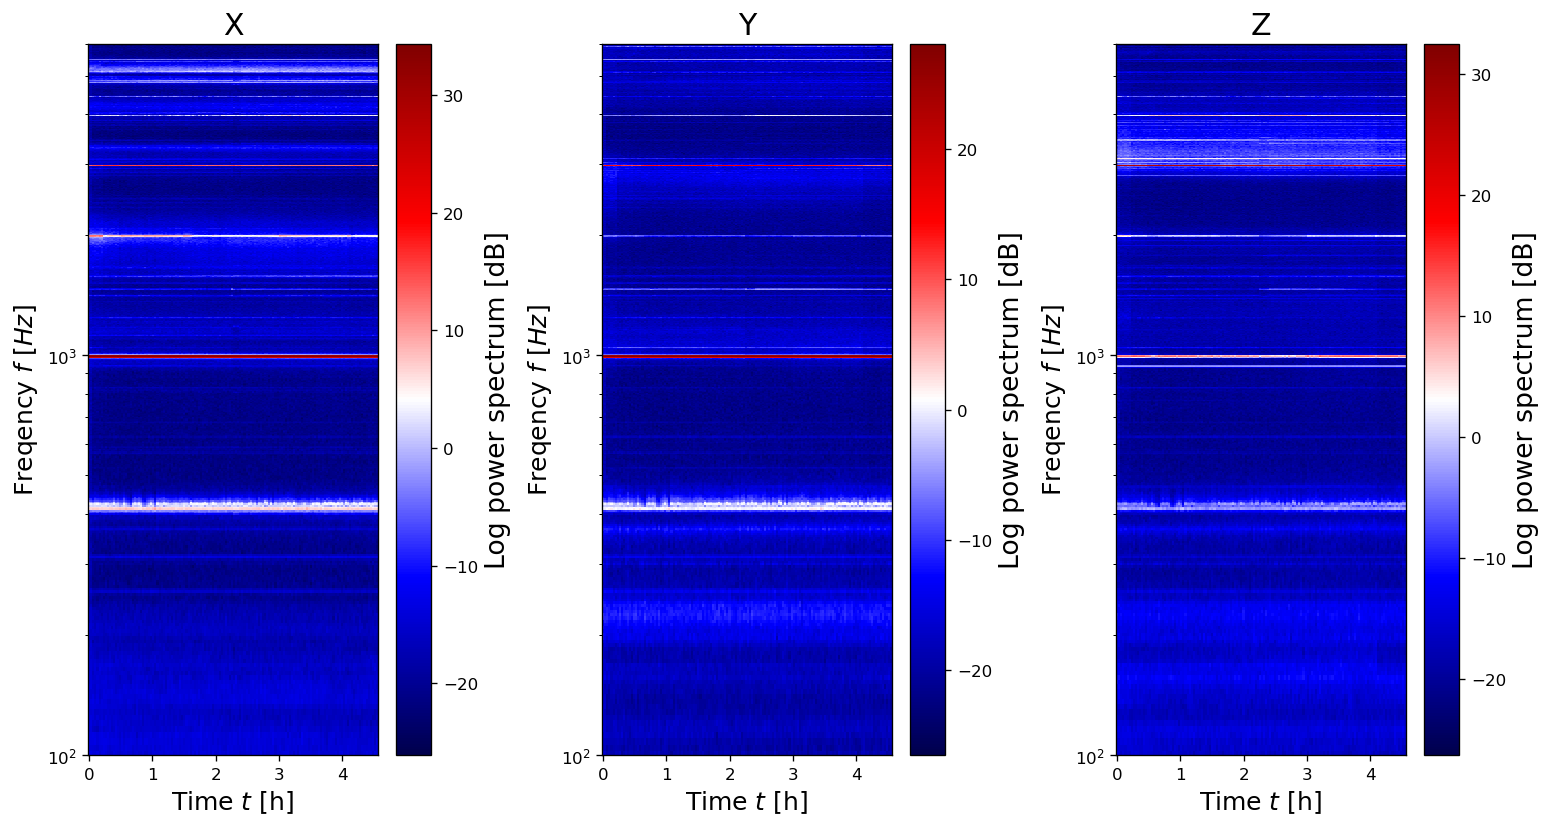

In [24]:
fig = plt.figure(3,dpi=120,figsize=(13,7))
ax = fig.subplots(1,3)

print(ax.shape)

dirtitle = ["X","Y","Z"]

for i in range(3):
    #mapper = ax[i].pcolormesh(time,freq,10*np.log10(fft_map[:,:,i]/0.11444),cmap='seismic')
    mapper = ax[i].pcolormesh(time,freq,10*np.log10(fft_map[:,:,i]/0.01**2),cmap='seismic')
    ax[i].set_yscale('log')
    ax[i].set_ylim(100,6000)
    ax[i].set_title(dirtitle[i],fontsize=18)
    ax[i].set_ylabel("Freqency $f$ [$Hz$]",fontsize=15)
    ax[i].set_xlabel("Time $t$ [h]",fontsize=15)
    pp = fig.colorbar(mapper,ax=ax[i], orientation="vertical")
    pp.set_label("Log power spectrum [dB]",fontsize=16)
    
fig.tight_layout()
plt.show()

In [26]:
#[1~4KHz,number of data,]

import time
from tqdm.notebook import trange

peak_input = [1000,1500,2000,2500,3000,3500]
num_peak = len(peak_input)
dir_save_data = os.path.join(os.getcwd(),'py_data','peak_fft_data.npy')


if not os.path.isdir("./py_data"):
    os.mkdir("./py_data")

if not os.path.isfile(dir_save_data):

    peak_fft_data = np.zeros((num_peak,1000000,5))
    s_rate = 80000
    time_tick = 9.7/5
    counter = 0

    for i in trange(len(data_list)):
        each_data = data_list[i]
        acc_x = each_data[200:-100,0]
        acc_y = each_data[200:-100,1]
        acc_z = each_data[200:-100,2]

        acc = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

        fft_x = ngi.myFFT(acc_x,1/s_rate,0.1,0.4)
        fft_y = ngi.myFFT(acc_y,1/s_rate,0.1,0.4)
        fft_z = ngi.myFFT(acc_z,1/s_rate,0.1,0.4)
        fft = ngi.myFFT(acc,1/s_rate,0.1,0.4)
        #print(counter)

        peak_fft_data[:,counter,0] = length[i,0]
        for k,fft_data in enumerate([fft,fft_x,fft_y,fft_z]):
            #print(peak_data)
            try:
                peak_fft_data[:,counter,k+1] = ngi.getPeak(fft_data,[peak_input,50],picked_data=20)[:,1]
            except ValueError as error:
                print('Error Counter : %d'% (counter))

        counter = counter+1

    logi = peak_fft_data[1,:,2] != 0
    peak_fft_data = peak_fft_data[:,logi,:]
    np.save(dir_save_data,peak_fft_data)
else:
    peak_fft_data = np.load(dir_save_data)


  0%|          | 0/140 [00:00<?, ?it/s]

# ピークの推移

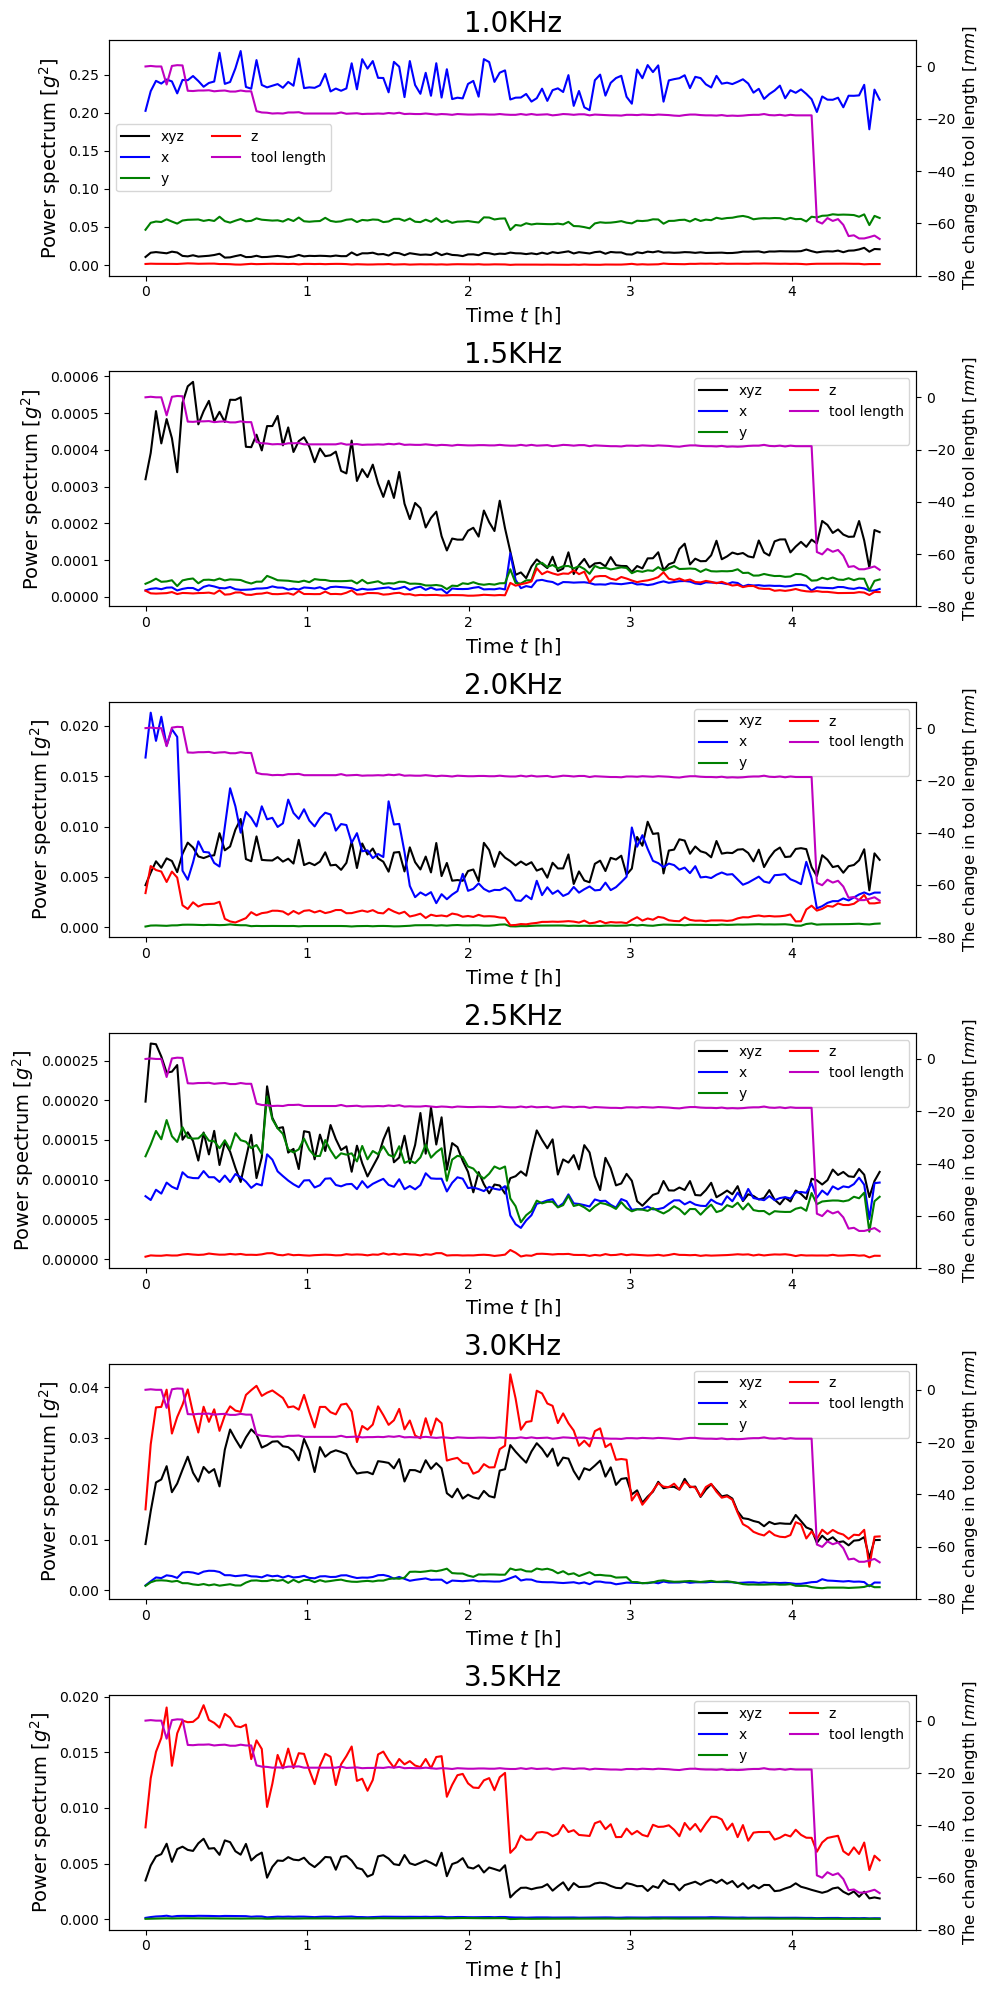

In [27]:
import matplotlib.pyplot as plt


fig = plt.figure(i,figsize=(10,20),dpi=100)
ax = fig.subplots(num_peak,1)
ar = ax.ravel()

set_color = ["k","b","g","r"]
for i in range(num_peak):
    each_peak = peak_fft_data[i,:,:]
    peak_title = str(peak_input[i]/1000) + "KHz"
    lines = []
    for j in range(4):
        
        lines.extend( ar[i].plot(each_peak[:,0],each_peak[:,j+1],color=set_color[j]))
        #lines.extend(line)
        ar[i].set_title(peak_title,fontsize=20)
        ar[i].set_ylabel("Power spectrum [$g^2$]", fontsize=14)
        ar[i].set_xlabel("Time $t$ [h]", fontsize=14)
        
        
        
    ax2 = ar[i].twinx()
    lines.extend( ax2.plot(length[:,0],length[:,2],color='m'))
    ax2.set_ylim(-80,10)
    ax2.get_yaxis().get_major_formatter().set_useOffset(False)
    ax2.set_ylabel("The change in tool length [$mm$]",fontsize=12)
    ar[i].legend(lines,["xyz","x","y","z","tool length"],ncol=2)
    #ar[i].legend(["xyz","x","y","z"],ncol=2)

fig.tight_layout()
plt.show()

# Wavelet解析
### 結果は別途添付します。